## Cleaning and Preprocessig Combined

#### Import data

In [18]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
import nltk
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings

In [24]:
#LIAR = pd.read_csv("/content/sample_data/LIAR.csv", index_col=0)
df = pd.read_csv("LIAR.csv", index_col=0)
columns = ["id",
           "label",
           "statement",
           "subject",
           "speaker",
           "job_title",
           "state_info",
           "party_affiliation",
           "barely_true_counts",
           "false_counts",
           "half_true_counts",
           "mostly_true_counts",
           "pants_on_fire_counts",
           "context",
           "justification"]
df.columns = columns

#### Deal with Missing Values

In [25]:
# Define columns with missing values
columns_with_missing = ['subject', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
                        'mostly_true_counts', 'pants_on_fire_counts', 'context', 'justification']

# Drop rows with missing values in specified columns
df.dropna(subset=columns_with_missing, inplace=True)

# Fill missing values in 'job_title' column
df['job_title'].fillna(pd.Series(np.random.choice(df['job_title'].dropna(), size=len(df))), inplace=True)

# Fill missing values in 'state_info' column
df['state_info'].fillna(pd.Series(np.random.choice(df['state_info'].dropna(), size=len(df))), inplace=True)


#### Map to binary outcome

In [26]:
# Combine 'context' and 'statement' columns
df['statement'] = df['context'] + ' ' + df['statement']
# Map labels to integers
label_mapping = {"pants-fire": 0, "FALSE": 0, "barely-true": 0, "half-true": 1, "mostly-true": 1, "TRUE": 1}
df['integer_label'] = df['label'].map(label_mapping).fillna(-1)
# Split 'subject' column and expand into separate columns
df = pd.concat([df, df['subject'].str.split(',', expand=True).iloc[:, :4].add_prefix('subject')], axis=1)
# Drop unnecessary columns
df.drop(['label', 'subject'], axis=1, inplace=True)
df.integer_label.value_counts()

integer_label
1    7017
0    5548
Name: count, dtype: int64

#### Encoding Categorical Variables

In [7]:
def top_n_encoder(series, n,prefix = None):
    '''
    series: a pd series
    n: number of top frequent categories to be encoded
    '''
    series = series.copy()
    counts = series.value_counts()
    mask = series.isin(counts.iloc[:n].index)
    series[~mask] = "other"
    return pd.get_dummies(series,prefix = prefix)

encoded_job_title = top_n_encoder(df.job_title.str.lower(),n = 50,prefix = "job")
encoded_party = top_n_encoder(df.party_affiliation.str.lower(),n = 50,prefix = "party")
encoded_speaker = top_n_encoder(df.speaker.str.lower(),n = 50,prefix = "speaker")
encoded_state_info = top_n_encoder(df.state_info.str.lower(),n = 50,prefix = "state_info") #added this line
# encoded_context = top_n_encoder(df.context.str.lower(), n = 150,prefix = "context")
encoded_subject1 = top_n_encoder(df.subject1.str.lower(),n = 30, prefix = "subject1")
encoded_subject2 = top_n_encoder(df.subject2.str.lower(),n = 30,prefix = "subject2")
encoded_subject3 = top_n_encoder(df.subject3.str.lower(),n = 30,prefix = "subject3")
encoded_subject4 = top_n_encoder(df.subject4.str.lower(),n = 30,prefix = "subject4")

#categorical_features = pd.concat([encoded_job_title,encoded_party,encoded_speaker,encoded_context,
#                                  encoded_subject1,encoded_subject2,encoded_subject3,encoded_subject4],axis = 1)
# categorical_features = pd.concat([encoded_job_title,encoded_party,encoded_speaker,encoded_context],axis = 1)
categorical_features = pd.concat([encoded_job_title,encoded_party,encoded_speaker,
                                  encoded_subject1,encoded_subject2,encoded_subject3,encoded_subject4],axis = 1)

df = pd.concat([df.reset_index(),categorical_features.reset_index()],axis=1) # concat encoded cols
df = df.drop(columns=['job_title','party_affiliation','speaker','state_info','index',
                      'subject1','subject2','subject3','subject4']) # drop oringinal cols
#df = df.drop(columns=['job_title','party_affiliation','speaker','state_info','context','index',
#                      'subject1','subject2','subject3','subject4']) # drop oringinal cols

#### Cleaning the Statements

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/savannah/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

stemmer = PorterStemmer()
def stem_sentence(sentence):
    token_words = word_tokenize(sentence)
    return " ".join(stemmer.stem(word) for word in token_words)

df['statement_clean'] = df.statement.apply(clean_text)
df = df.drop(columns=['statement'])
df['statement'] = df['statement_clean'].apply(stem_sentence)
df = df.drop(columns=['statement_clean'])

/var/folders/4w/xwbqdm5n0k372fhky2my_plh0000gn/T/ipykernel_60708/199755370.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding


#### word2vec embedding

In [10]:
# Extract features and labels
X = [[vocab for vocab in data['statement'].split() if len(vocab) > 1] for _, data in df.iterrows()]
y = df['integer_label'].values

In [11]:
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=10, window=5, min_count=1)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=20)
vocab_size = len(tokenizer.word_index) + 1
embedding = np.zeros((vocab_size, 10))

for word, i in tokenizer.word_index.items():
    embedding[i] = w2v_model.wv[word]

####  Deep learning (LSTM, RNN)

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=10, weights=[embedding], input_length=20, trainable=False))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(64))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(2, activation='softmax'))
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = Adam(0.0005)
model.compile(optimizer, loss, metrics=['accuracy'])

2021-12-15 03:56:40.746522: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model2 = Sequential()
model2.add(Embedding(vocab_size, output_dim=10, weights=[embedding], input_length=20, trainable=False))
model2.add(GRU(128, return_sequences=True))
model2.add(SimpleRNN(64))
model2.add(Dense(32 , activation = 'relu'))
model2.add(Dense(2, activation='softmax'))
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = Adam(0.0005)
model2.compile(optimizer, loss, metrics=['accuracy'])

In [15]:
y = tf.keras.utils.to_categorical(y, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 
history = model.fit(X_train, y_train, validation_split=0.125, epochs=10, steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 19s 123ms/step - loss: 0.6731 - accuracy: 0.5814 - val_loss: 0.6675 - val_accuracy: 0.5979
Epoch 2/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6664 - accuracy: 0.5930 - val_loss: 0.6746 - val_accuracy: 0.5893
Epoch 3/10
100/100 [==============================] - 17s 172ms/step - loss: 0.6664 - accuracy: 0.5900 - val_loss: 0.6657 - val_accuracy: 0.5916
Epoch 4/10
100/100 [==============================] - 16s 164ms/step - loss: 0.6646 - accuracy: 0.5946 - val_loss: 0.6661 - val_accuracy: 0.5995
Epoch 5/10
100/100 [==============================] - 15s 150ms/step - loss: 0.6641 - accuracy: 0.5978 - val_loss: 0.6638 - val_accuracy: 0.6090
Epoch 6/10
100/100 [==============================] - 19s 188ms/step - loss: 0.6621 - accuracy: 0.6017 - val_loss: 0.6685 - val_accuracy: 0.5853
Epoch 7/10
100/100 [==============================] - 22s 222ms/step - loss: 0.6618 - accuracy: 0.6002 - val_loss: 0.6703 - val_ac

In [16]:
history2 = model2.fit(X_train, y_train, validation_split=0.125, epochs=10, steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 20s 142ms/step - loss: 0.6835 - accuracy: 0.5578 - val_loss: 0.6729 - val_accuracy: 0.5869
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 0.6723 - accuracy: 0.5780 - val_loss: 0.6787 - val_accuracy: 0.5821
Epoch 3/10
100/100 [==============================] - 10s 99ms/step - loss: 0.6677 - accuracy: 0.5944 - val_loss: 0.6692 - val_accuracy: 0.5837
Epoch 4/10
100/100 [==============================] - 7s 68ms/step - loss: 0.6642 - accuracy: 0.5967 - val_loss: 0.6699 - val_accuracy: 0.5695
Epoch 5/10
100/100 [==============================] - 7s 69ms/step - loss: 0.6625 - accuracy: 0.6008 - val_loss: 0.6731 - val_accuracy: 0.5766
Epoch 6/10
100/100 [==============================] - 9s 92ms/step - loss: 0.6599 - accuracy: 0.6038 - val_loss: 0.6711 - val_accuracy: 0.5845
Epoch 7/10
100/100 [==============================] - 9s 94ms/step - loss: 0.6569 - accuracy: 0.6134 - val_loss: 0.6747 - val_accuracy: 0

In [17]:
y_pred = model.predict(X).argmax(axis=-1).astype(int)
y = np.argmax(y, axis=1)
print(y_pred)
print(y)
print('accuracy on all data (LSTM):', accuracy_score(y, y_pred))
print(f"zeros: {np.count_nonzero(y_pred==0)} nonzeros: {np.count_nonzero(y_pred)}")

[0 1 0 ... 0 0 1]
[0 1 1 ... 1 0 0]
accuracy on all data (LSTM): 0.6124012638230648
zeros: 3965 nonzeros: 8695


In [18]:
y_pred2 = model2.predict(X).argmax(axis=-1).astype(int)
print(y_pred2)
print(y)
print('accuracy on all data (GRU+RNN):', accuracy_score(y, y_pred2))
print(f"zeros: {np.count_nonzero(y_pred2==0)} nonzeros: {np.count_nonzero(y_pred2)}")

[0 1 0 ... 1 0 1]
[0 1 1 ... 1 0 0]
accuracy on all data (GRU+RNN): 0.6230647709320695
zeros: 3732 nonzeros: 8928


In [19]:
df2 = df.copy()
df['pred'] = y_pred
df2['pred'] = y_pred2

#### Split data and test result

In [20]:
y = df['integer_label'].astype(int)
X = df.drop(columns=['integer_label','id', 'statement', 'context'])


col_names = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
features = X[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X[col_names] = features

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0, stratify=y_dev)

In [21]:
rfc = RandomForestClassifier()
model = rfc.fit(X_dev, y_dev)
y_pred = model.predict(X_test)

In [22]:
xgb = XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1, eval_metric="logloss")
xgb.fit(X_dev, y_dev)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [23]:
hgbc = HistGradientBoostingClassifier(max_depth=8, learning_rate=0.1, warm_start=True)
gbc = GradientBoostingClassifier(max_depth=8, learning_rate=0.1, warm_start = True)

hgbc.fit(X_dev, y_dev)
gbc.fit(X_dev, y_dev)

GradientBoostingClassifier(max_depth=8, warm_start=True)

In [24]:
print("Random Forest Performance using LSTM:", accuracy_score(y_test, y_pred))
print("XGBoost Performance using LSTM:", xgb.score(X_test, y_test))
print("Hist Gradient Boosting Performance using LSTM:", hgbc.score(X_test, y_test))
print("Gradient Boosting Performance using LSTM:", gbc.score(X_test, y_test))

Random Forest Performance using LSTM: 0.7014218009478673
XGBoost Performance using LSTM: 0.7144549763033176
Hist Gradient Boosting Performance using LSTM: 0.7318325434439179
Gradient Boosting Performance using LSTM: 0.7239336492890995


In [26]:
y = df2['integer_label'].astype(int)
X = df2.drop(columns=['integer_label','id', 'statement', 'context'])


col_names = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
features = X[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X[col_names] = features

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

rfc = RandomForestClassifier()
model = rfc.fit(X_dev, y_dev)
y_pred = model.predict(X_test)

xgb = XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.05, eval_metric="logloss")
xgb.fit(X_dev, y_dev)

hgbc = HistGradientBoostingClassifier(max_depth=8, learning_rate=0.05, warm_start=True)
gbc = GradientBoostingClassifier(max_depth=8, learning_rate=0.05, warm_start = True)

hgbc.fit(X_dev, y_dev)
gbc.fit(X_dev, y_dev)

print("Random Forest Performance using RNN:", accuracy_score(y_test, y_pred))
print("XGBoost Performance using RNN:", xgb.score(X_test, y_test))
print("Hist Gradient Boosting Performance using RNN:", hgbc.score(X_test, y_test))
print("Gradient Boosting Performance using RNN:", gbc.score(X_test, y_test))

Random Forest Performance using RNN: 0.717219589257504
XGBoost Performance using RNN: 0.7468404423380727
Hist Gradient Boosting Performance using RNN: 0.7523696682464455
Gradient Boosting Performance using RNN: 0.7397314375987362


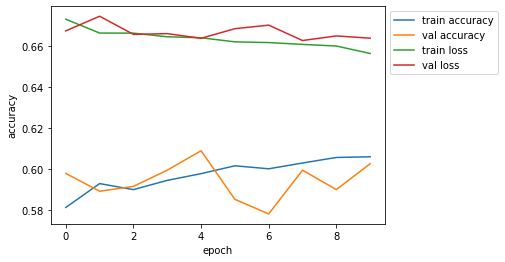

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy', 'train loss', 'val loss'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

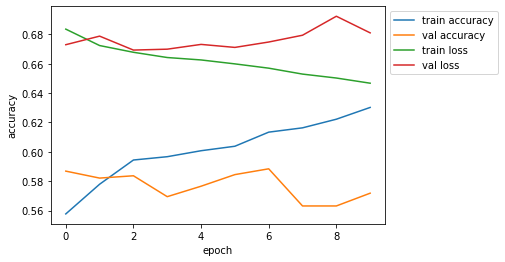

In [28]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy', 'train loss', 'val loss'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()